In [43]:
import copy as cp
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
target = pd.read_csv('data/SampleSubmissionStage1.csv').set_index('ID').drop('Pred', axis=1)
target['Season'] = target.index.map(lambda i: i[:4])
target['team_a'] = target.index.map(lambda i: i[5:9])
target['team_b'] = target.index.map(lambda i: i[10:14])
target['in_target'] = True
target.sample()

,Season,team_a,team_b,in_target
ID,,,,
2015_1129_1234,2015,1129,1234,True


In [3]:
ncaa_games = pd.read_csv('data/NCAATourneyCompactResults.csv')
ncaa_games = ncaa_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
ncaa_games['diff'] = ncaa_games['WScore'] - ncaa_games['LScore']
print(ncaa_games.shape)
ncaa_games.sample()

(2117, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
2040,2016,144,1323,61,1458,56,N,0,5


In [4]:
regular_games = pd.read_csv('data/RegularSeasonCompactResults.csv')
regular_games = regular_games.astype({
    'LTeamID': str,
    'WTeamID': str,
    'Season': str
})
regular_games['diff'] = regular_games['WScore'] - regular_games['LScore']
print(regular_games.shape)
regular_games.sample()

(150684, 9)


,Season,DayNum,WTeamID,WScore,LTeamID,LScore,WLoc,NumOT,diff
103232,2009,18,1268,89,1436,74,H,1,15


In [5]:
from sklearn.decomposition import NMF


data = cp.deepcopy(ncaa_games)
data['team_a'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) < int(t[1]) else t[1], axis=1)
data['team_b'] = data[['WTeamID', 'LTeamID']].apply(lambda t: t[0] if int(t[0]) > int(t[1]) else t[1], axis=1)
data['a_win'] = data['WTeamID'] == data['team_a']
data = data[['Season', 'team_a', 'team_b', 'a_win']]
data = pd.concat([data, target.reset_index(drop=True)]).fillna(0).astype({'a_win': bool, 'in_target': bool})

lags = 3
for team, opponent_team in [('a', 'b'), ('b','a')]:
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_season = regular_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_season_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_season[
            'won_in_season_{}_lag-{}'.format(team, l)] = won_in_season[
            'won_in_season_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_season.drop('won_in_season_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_season,
                    left_on=['Season', 'team_{}'.format(team)], right_index=True,
                    how='left')
    
    
    # SEASON WINS AGAINST THE OPPONENT
    season_wins_against_opponent = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
        .rename(columns={'diff': 'season_wins_against_opponent_{}'.format(team)}).fillna(0)
    for l in range(1, lags+1):
        season_wins_against_opponent['season_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
            season_wins_against_opponent['season_wins_against_opponent_{}'.format(team)].shift(l)
    season_wins_against_opponent.drop('season_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, season_wins_against_opponent,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # AVERAGE DIFF TO OPPONENT IN THE SEASON
    average_win_diff = regular_games.groupby(['Season', 'WTeamID', 'LTeamID']).mean()[['diff']]\
        .rename(columns={'diff': 'average_win_diff_{}'.format(team)})
    for l in range(1, lags+1):
        average_win_diff[
            'average_win_diff_{}_lag-{}'.format(team, l)] = average_win_diff[
            'average_win_diff_{}'.format(team)
        ].shift(l).fillna(0)
    average_win_diff.drop('average_win_diff_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, average_win_diff,
                    left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
                    right_index=True,
                    how='left').fillna(0)
    
    
    # GAMES WON IN PAST TOURNAMENTS
    won_in_ncaa = ncaa_games\
        .groupby(['Season', 'WTeamID']).count()[['diff']]\
        .rename(columns={'diff': 'won_in_ncaa_{}'.format(team)})
    for l in range(1, lags+1):
        won_in_ncaa[
            'won_in_ncaa_{}_lag-{}'.format(team, l)] = won_in_ncaa[
            'won_in_ncaa_{}'.format(team)
        ].shift(l).fillna(0)
    won_in_ncaa.drop('won_in_ncaa_{}'.format(team), inplace=True, axis=1)
    data = pd.merge(data, won_in_ncaa,
                    left_on=['Season', 'team_{}'.format(team)], right_index=True,
                    how='left').fillna(0)
    
    # NCAA WINS AGAINST THE OPPONENT
#     ncaa_wins_against_opponent = ncaa_games.groupby(['Season', 'WTeamID', 'LTeamID']).sum()[['diff']]\
#         .rename(columns={'diff': 'ncaa_wins_against_opponent_{}'.format(team)}).sort_index()
#     for l in range(1, lags+1):
#         ncaa_wins_against_opponent['ncaa_wins_against_opponent_{}_lag-{}'.format(team, l)] =\
#             ncaa_wins_against_opponent['ncaa_wins_against_opponent_{}'.format(team)].shift(l).fillna(0)
#     ncaa_wins_against_opponent.drop('ncaa_wins_against_opponent_{}'.format(team), inplace=True, axis=1)
#     data = pd.merge(data, ncaa_wins_against_opponent,
#                     left_on=['Season', 'team_{}'.format(team), 'team_{}'.format(opponent_team)],
#                     right_index=True,
#                     how='left').fillna(0)
    
    
data = data.dropna()
data.head(5)

,Season,a_win,in_target,team_a,team_b,won_in_season_a_lag-1,won_in_season_a_lag-2,won_in_season_a_lag-3,season_wins_against_opponent_a_lag-1,season_wins_against_opponent_a_lag-2,...,won_in_season_b_lag-3,season_wins_against_opponent_b_lag-1,season_wins_against_opponent_b_lag-2,season_wins_against_opponent_b_lag-3,average_win_diff_b_lag-1,average_win_diff_b_lag-2,average_win_diff_b_lag-3,won_in_ncaa_b_lag-1,won_in_ncaa_b_lag-2,won_in_ncaa_b_lag-3
0,1985,True,False,1116,1234,17.0,11.0,18.0,0.0,0.0,...,15.0,29.0,13.0,10.0,29.0,13.0,5.0,0.0,0.0,0.0
1,1985,True,False,1120,1345,15.0,11.0,21.0,0.0,0.0,...,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,1985,True,False,1207,1250,17.0,20.0,13.0,0.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1985,True,False,1229,1425,23.0,13.0,10.0,0.0,0.0,...,15.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1985,True,False,1242,1325,12.0,13.0,8.0,0.0,0.0,...,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


#### Exploratory plots

In [24]:
data.columns

Index(['Season', 'a_win', 'in_target', 'team_a', 'team_b',
       'won_in_season_a_lag-1', 'won_in_season_a_lag-2',
       'won_in_season_a_lag-3', 'season_wins_against_opponent_a_lag-1',
       'season_wins_against_opponent_a_lag-2',
       'season_wins_against_opponent_a_lag-3', 'average_win_diff_a_lag-1',
       'average_win_diff_a_lag-2', 'average_win_diff_a_lag-3',
       'won_in_ncaa_a_lag-1', 'won_in_ncaa_a_lag-2', 'won_in_ncaa_a_lag-3',
       'won_in_season_b_lag-1', 'won_in_season_b_lag-2',
       'won_in_season_b_lag-3', 'season_wins_against_opponent_b_lag-1',
       'season_wins_against_opponent_b_lag-2',
       'season_wins_against_opponent_b_lag-3', 'average_win_diff_b_lag-1',
       'average_win_diff_b_lag-2', 'average_win_diff_b_lag-3',
       'won_in_ncaa_b_lag-1', 'won_in_ncaa_b_lag-2', 'won_in_ncaa_b_lag-3'],
      dtype='object')

In [61]:
df_scatter.a_win.value_counts()

False    10152
True      1077
Name: a_win, dtype: int64

In [62]:
df_scatter_1 = data[['a_win', 'won_in_season_a_lag-1', 'season_wins_against_opponent_a_lag-1', 'average_win_diff_a_lag-1', ]]
df_scatter_2 = data[['a_win', 'won_in_ncaa_a_lag-1', 'won_in_season_b_lag-1', 'season_wins_against_opponent_b_lag-1', ]]
df_scatter_3 = data[['a_win', 'average_win_diff_b_lag-1', 'won_in_ncaa_b_lag-1']]

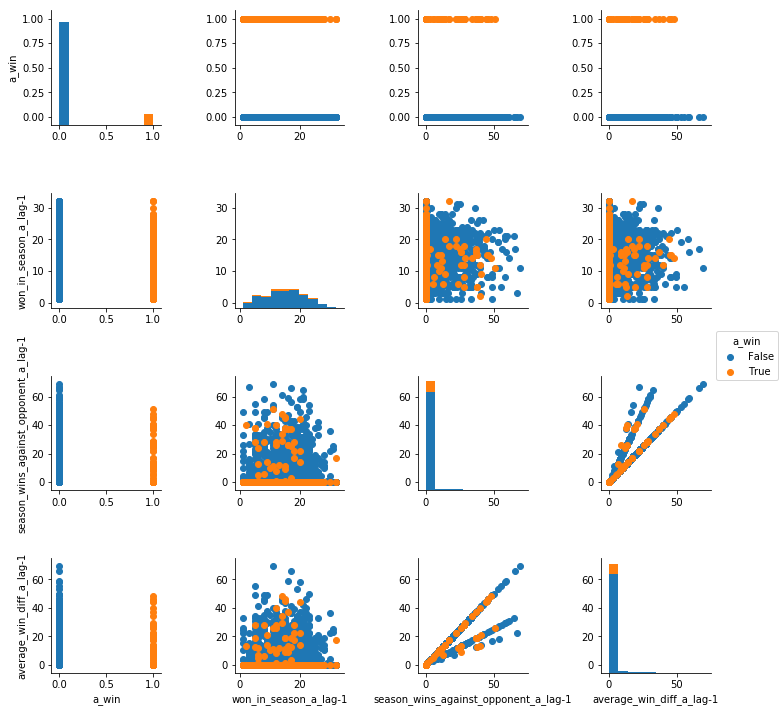

In [63]:
g = sns.PairGrid(df_scatter_1, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

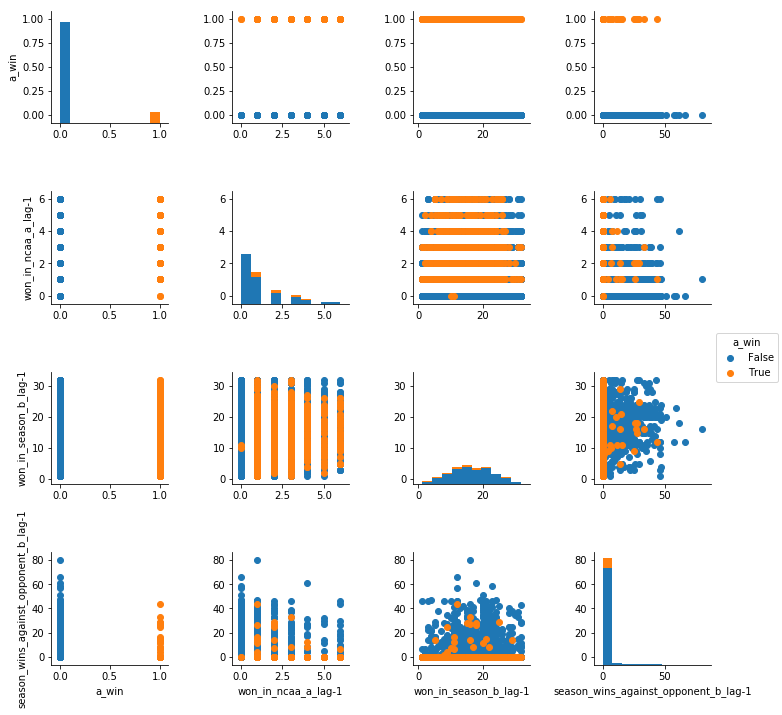

In [65]:
g = sns.PairGrid(df_scatter_2, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

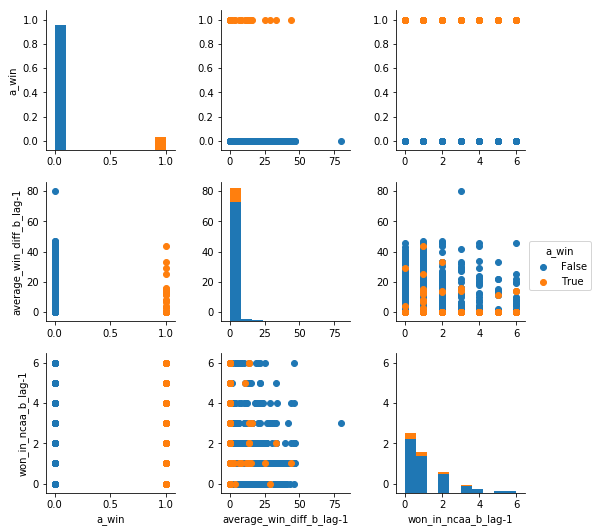

In [67]:
g = sns.PairGrid(df_scatter_3, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

# Some extra plots

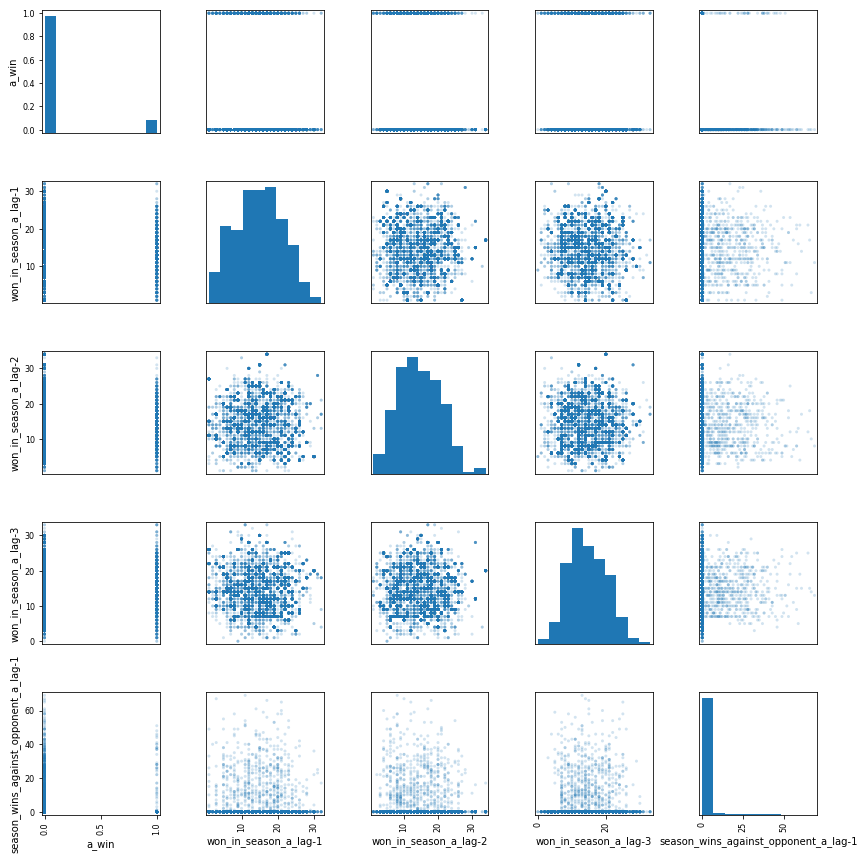

In [40]:
df_scatter = data[['a_win', 'won_in_season_a_lag-1', 'won_in_season_a_lag-2',
       'won_in_season_a_lag-3', 'season_wins_against_opponent_a_lag-1',]]
axes = pd.plotting.scatter_matrix(df_scatter, alpha=0.2, figsize = (12,12))
plt.tight_layout()
plt.savefig('scatter_matrix.png')

In [33]:
color = df_scatter.a_win.values * 1

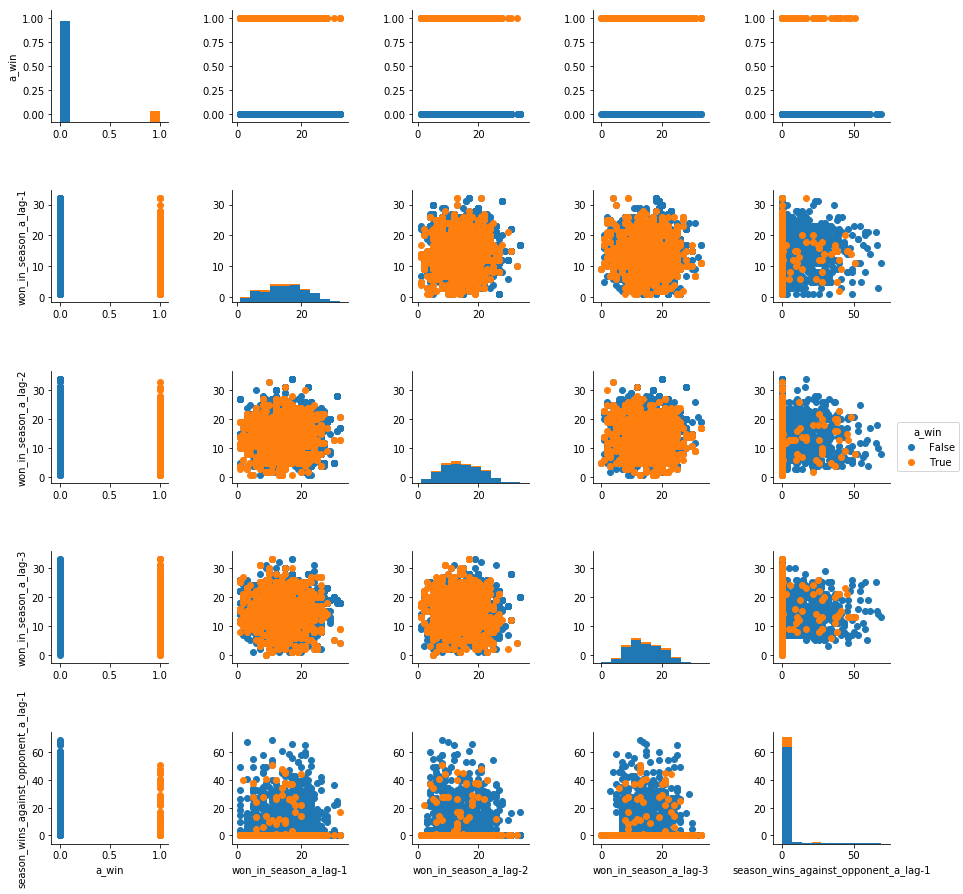

In [49]:
g = sns.PairGrid(df_scatter, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

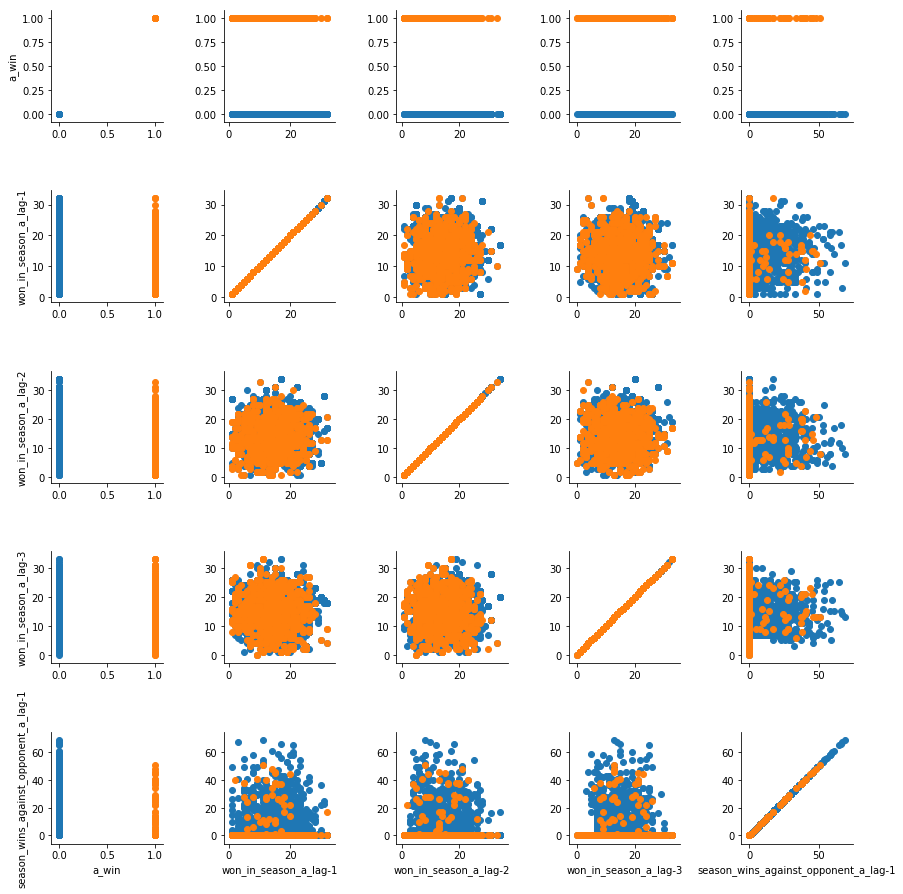

In [50]:
g = sns.PairGrid(df_scatter, hue="a_win")
g.map(plt.scatter)

/Users/feliuserraburriel/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: divide by zero encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/feliuserraburriel/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/kernels.py:128: RuntimeWarning: invalid value encountered in true_divide
  return (1. / np.sqrt(2 * np.pi)) * np.exp(-(Xi - x)**2 / (h**2 * 2.))
/Users/feliuserraburriel/anaconda3/lib/python3.6/site-packages/statsmodels/nonparametric/_kernel_base.py:514: RuntimeWarning: invalid value encountered in true_divide
  dens = Kval.prod(axis=1) / np.prod(bw[iscontinuous])
/Users/feliuserraburriel/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1533: UserWarning: Warning: converting a masked element to nan.
  self.zmax = float(z.max())
/Users/feliuserraburriel/anaconda3/lib/python3.6/site-packages/matplotlib/contour.py:1534: UserWarning: Warning: converting a maske

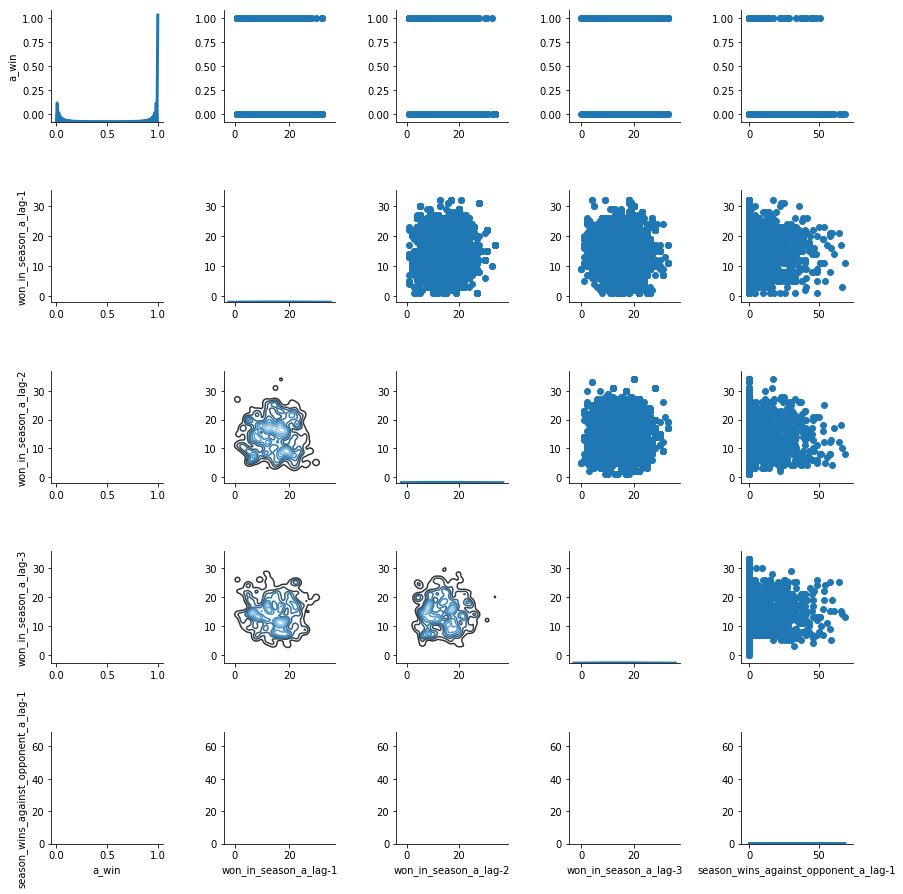

In [51]:
g = sns.PairGrid(df_scatter)
g.map_upper(plt.scatter)
g.map_lower(sns.kdeplot, cmap="Blues_d")
g.map_diag(sns.kdeplot, lw=3, legend=False);

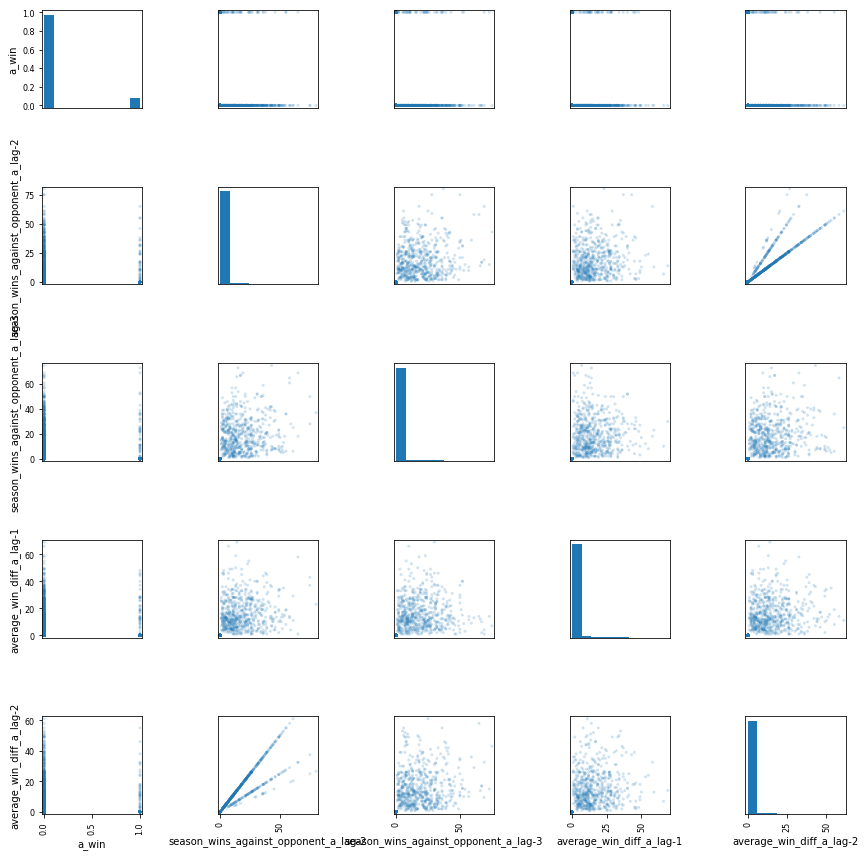

In [56]:
df_scatter = data[['a_win','season_wins_against_opponent_a_lag-2',
       'season_wins_against_opponent_a_lag-3', 'average_win_diff_a_lag-1',
       'average_win_diff_a_lag-2',]]
axes = pd.plotting.scatter_matrix(df_scatter, alpha=0.2, figsize = (12,12))
plt.tight_layout()
plt.savefig('scatter_matrix.png')

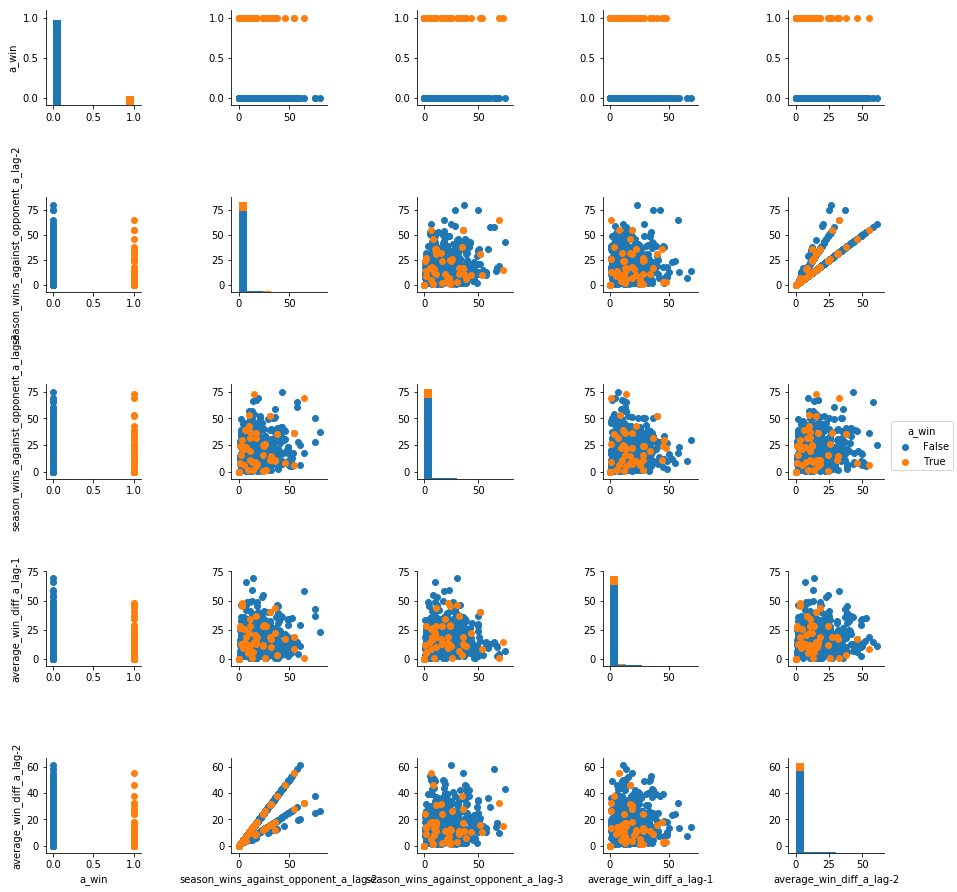

In [57]:
g = sns.PairGrid(df_scatter, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()

In [59]:
df_scatter = data[['a_win','won_in_ncaa_a_lag-1', 'won_in_ncaa_a_lag-2', 'won_in_ncaa_a_lag-3',
       'won_in_season_b_lag-1', 'won_in_season_b_lag-2',]]

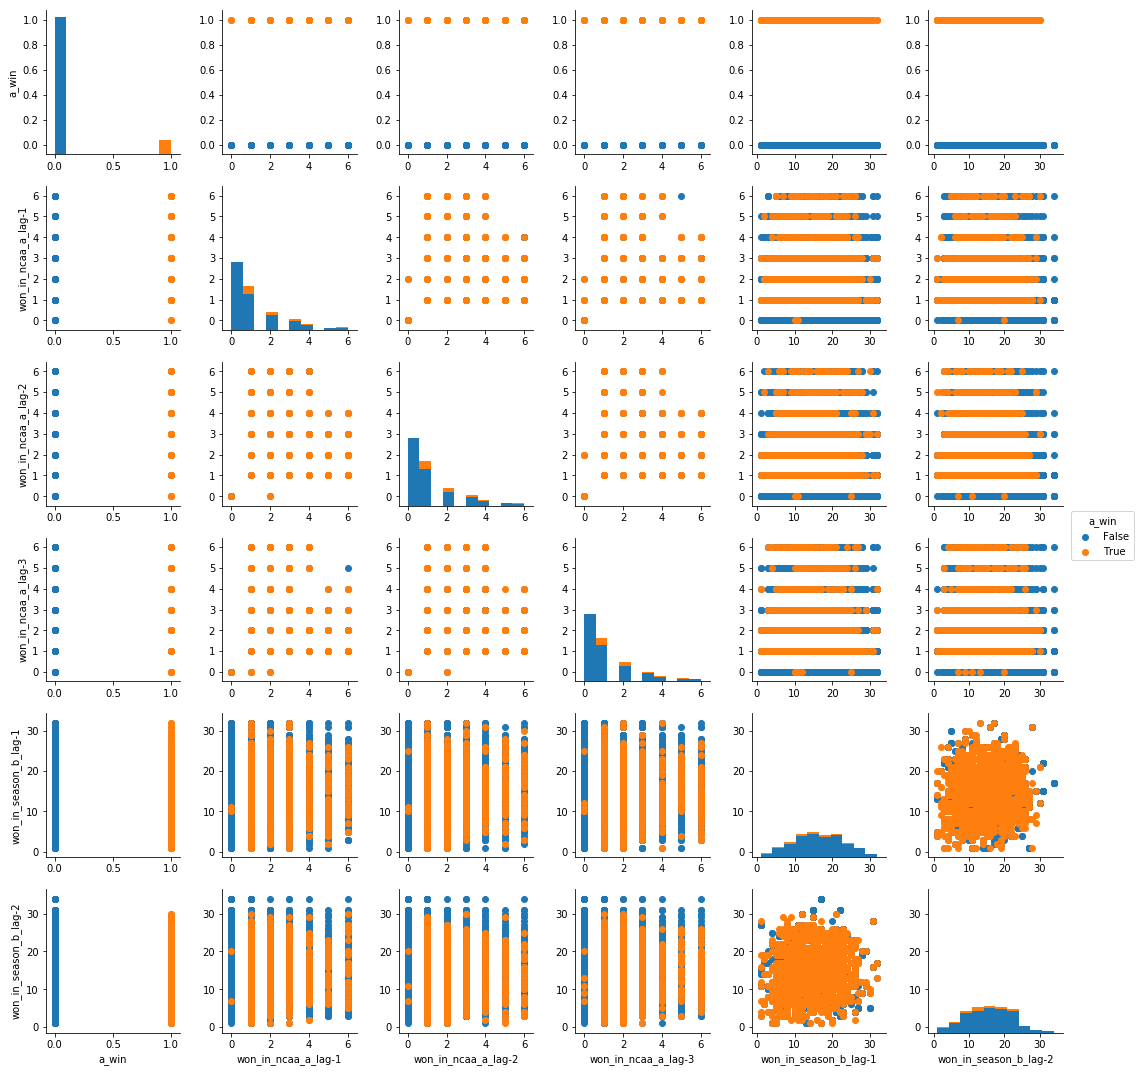

In [60]:
g = sns.PairGrid(df_scatter, hue="a_win", size = 2.5, )
g.map_diag(plt.hist)
g.map_offdiag(plt.scatter)
g.add_legend()